## Deep Learning Black-Scholes Formula - III

In [1]:
import numpy as np
import torch
import csv
import matplotlib.pyplot as plt

In [19]:
dataset = []
with open('../data/black_scholes_with_greeks.csv', newline='\n') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  for row in reader:
    dataset.append(row)

train_set, test_set = np.array(dataset[:4096], dtype=float), np.array(dataset[4096:], dtype=float)
train_features, train_labels = torch.from_numpy(train_set[:, 0:5]), torch.from_numpy(train_set[:, 5:])
test_features, test_labels = torch.from_numpy(test_set[:, 0:5]), torch.from_numpy(test_set[:, 5:])

In [20]:
batch_size = 256
train_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(train_features, train_labels),
                                         batch_size,
                                         shuffle=True)
test_iter = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(test_features, test_labels),
                                        batch_size,
                                        shuffle=False)


In [21]:
num_inputs = 5
num_hidden = 20
num_outputs = 1

w1 = torch.nn.Parameter(torch.randn(num_inputs, num_hidden, requires_grad=True) * .01)
b1 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w2 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b2 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w3 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b3 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w4 = torch.nn.Parameter(torch.randn(num_hidden, num_hidden, requires_grad=True) * .01)
b4 = torch.nn.Parameter(torch.zeros(num_hidden, requires_grad=True))
w5 = torch.nn.Parameter(torch.randn(num_hidden, num_outputs, requires_grad=True) * .01)
b5 = torch.nn.Parameter(torch.zeros(num_outputs, requires_grad=True))

params = [w1, b1, w2, b2, w3, b3, w4, b4, w5, b5]

class Model(torch.nn.Module):
  def __init__(self, params) -> None:
    super(Model, self).__init__()
    self.softplus = torch.nn.Softplus()
    self.sigmoid = torch.nn.Sigmoid()
    self.w1 = params[0]
    self.b1 = params[1]
    self.w2 = params[2]
    self.b2 = params[3]
    self.w3 = params[4]
    self.b3 = params[5]
    self.w4 = params[6]
    self.b4 = params[7]
    self.w5 = params[8]
    self.b5 = params[9]

  def forward(self, x):
    y1 = self.softplus(torch.matmul(x,  self.w1) + self.b1)
    y2 = self.softplus(torch.matmul(y1, self.w2) + self.b2)
    y3 = self.softplus(torch.matmul(y2, self.w3) + self.b3)
    y4 = self.softplus(torch.matmul(y3, self.w4) + self.b4)
    out = torch.matmul(y4, self.w5) + self.b5

    deriv = torch.ones_like(out)
    deriv = torch.matmul(deriv, torch.transpose(self.w5, 0, 1)) * self.sigmoid(y4)
    deriv = torch.matmul(deriv, torch.transpose(self.w4, 0, 1)) * self.sigmoid(y3)
    deriv = torch.matmul(deriv, torch.transpose(self.w3, 0, 1)) * self.sigmoid(y2)
    deriv = torch.matmul(deriv, torch.transpose(self.w2, 0, 1)) * self.sigmoid(y1)
    deriv = torch.matmul(deriv, torch.transpose(self.w1, 0, 1)) * self.sigmoid(x)

    return out, deriv

model = Model(params)

In [22]:
loss = torch.nn.MSELoss()

In [56]:
learning_rate = 0.0005
optimizer = torch.optim.SGD(params, lr=learning_rate)

In [63]:
num_epochs = 10
for epoch in range(num_epochs):
  for X, y in train_iter:
    val, deriv = model(X.float())
    l1 = loss(val, y.float()[:, 0].reshape(val.shape))
    l2 = loss(deriv, y.float()[:, 1:].reshape(deriv.shape))
    l = l1 + l2

    optimizer.zero_grad()
    l.backward()
    optimizer.step()

  val, deriv = model(train_features.float())
  l1 = loss(val, train_labels.float()[:, 0].reshape(val.shape))
  l2 = loss(deriv, train_labels.float()[:, 1:].reshape(deriv.shape))
  l = l1 + l2
  print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.273957
epoch 2, loss 0.274586
epoch 3, loss 0.273312
epoch 4, loss 0.274006
epoch 5, loss 0.273182
epoch 6, loss 0.278113
epoch 7, loss 0.275056
epoch 8, loss 0.273039
epoch 9, loss 0.275632
epoch 10, loss 0.271818


In [64]:
torch.save(model.state_dict(), '../save/black_scholes_greeks.ckpt')

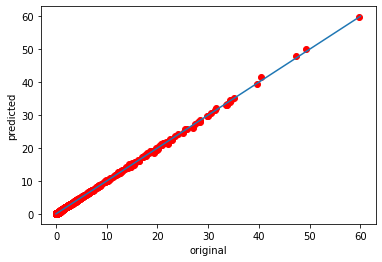

In [65]:
with torch.no_grad():
  val, deriv = model(train_features.float())
  predicted = val.numpy().reshape(-1)
  original = train_labels[:, 0].numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 60], [0, 60])
  plt.show()

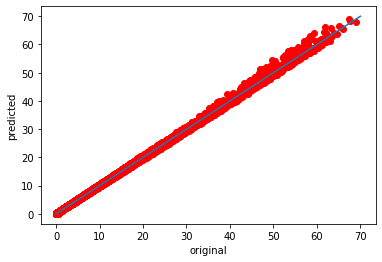

In [68]:
with torch.no_grad():
  val, deriv = model(test_features.float())
  predicted = val.numpy().reshape(-1)
  original = test_labels[:, 0].numpy().reshape(-1)

  plt.plot(original, predicted, 'ro')
  plt.xlabel("original")
  plt.ylabel("predicted")
  plt.plot([0, 70], [0, 70])
  plt.show()

In [22]:
from synthetic_black_scholes_data import value_call_option
import random

strike = random.uniform(7, 650)
spot = random.uniform(10, 500)
maturity = random.randint(1, 1095) / 365.
dividend = random.uniform(.0,  .03)
discount = random.uniform(.01, .03)
volatility = random.uniform(.05, .9)

price = value_call_option(strike, spot, maturity, dividend, discount, volatility) / strike
predicted = model(torch.tensor([spot / strike, maturity, dividend, discount, volatility])).detach()
print(price)
print(predicted)

0.5008855378998333
tensor([0.4817])
